# Stratify Scorecard for Review

As part of the score development process, the data scientist will review the output of their scores, but also seek feedback from stakeholders; these stakeholders may vary, but could include a product manager, other data scientists, lead investigators, etc. This review is an important part of the overall analytical lifecycle.

It is impractical to review all score output, and so we must sample cases for review.

The [first example](#Example1) shows how to select cases from the scorecard which are stratified across the overall score.

The [second example](#Example2) shows how to select instances of a single score which are stratified across the overall score.

In [1]:
import pyspark.sql.functions as f

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#### Loading the data

In [2]:
ROOT_PATH="gs://green-1-accelerators-1-username-dpr-stg-bucket/"
FILE_PATH="scoring/ScoreCard/CustomerScorecard"
CUSTOMER_PATH="customer/DocumentDataModel/CleansedDocumentDataModel.parquet"

In [3]:
scorecard = spark.read.parquet(ROOT_PATH+FILE_PATH)

In [4]:
customers = spark.read.parquet(ROOT_PATH+CUSTOMER_PATH)

## <a name="Example1" style="color:black">Example 1 - Sample cases from the scorecard</a>

This section shows how to obtain a sample of cases from the scorecard for review which has been stratified across the overall score in the scorecard.

### Review data

We start by analysing the score distribution to ensure that the overall distribution looks sensible.

In [5]:
#We use pandas as it has convenient functions to analyse distributions and the data size is not too large.
scorecard_pd = scorecard.toPandas()

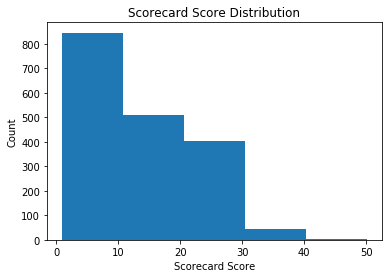

In [6]:
total_count, bins, patches = plt.hist(scorecard_pd.scorecardScore,bins=5)
plt.title("Scorecard Score Distribution")
plt.xlabel("Scorecard Score")
plt.ylabel("Count")
plt.show()

This distribution looks appropriate for our data. We would expect many cases to fall into the lowly scoring buckets, and much fewer to fall into the higher scoring buckets.

---

### Determine Bins and Sample Sizes

Next, we will formally bin the customers using the overall scorecard score and choose the fractions for each bin that we wish to sample. Here we use the bin values created when the histogram was made, although in practice you may wish to increase the number of bins first if greater granularity is required.

In this first step, we create a DataFrame containing:
1. the minimum and maximum score bin values (e.g. 1-10, 20-30, ...) 
1. the number of scored customers in each bin; and 
1. the number of customers we'd like to sample from each bin.

Note that when sampling later, the sampleCount is probabalistic, and so the exact number sampled may vary.

In [7]:
score_counts_pd = pd.DataFrame({"scorecardScoreMin":bins[:-1], "scorecardScoreMax":bins[1:], \
                                "totalCount":total_count, "sampleCount": [0,2,2,2,2]})

At this point we visually inspect what we are going to sample, in particular ensuring that the totalCount vs the sampleCount values are sensible. 

<span style="color:red"> *Note that the sample size should not be more than the total count.*</span>

In [8]:
score_counts_pd

,scorecardScoreMin,scorecardScoreMax,totalCount,sampleCount
0,1.000,10.816,845.0,0
1,10.816,20.632,508.0,2
2,20.632,30.448,405.0,2
3,30.448,40.264,46.0,2
4,40.264,50.080,2.0,2


In [9]:
#Ordinarily this function would be imported from an external library, however Quantexa does not currently
#maintain any python libraries, and so the function is included here directly.
def create_fractions_for_sample(score_counts_df, fraction_key,count_col ):
    """
    function to create custom dictionary of fractions for scorecard samples.
    @score_counts_df: pandas dataframe containing scores, total counts and size of required samples
    @fraction_key: the name of the column you are sampling over
    @count_col: the name of the column with group counts
    (The sampling is probabilistic and therefore the required sample sizes are 
    an approximation of the number of samples you will receive. It is therefore 
    advised to use 2 as the minimum sample size to give a higher chance of a sample being obtained.)
    output:
    @fractions_dict: a dictionay with the fraction_key as the key and the fraction size as the value
    @score_counts_df: input dataframe with an extra column added with the fraction sizes
    """
    fractions_dict = {}
    for index, row in score_counts_df.iterrows():
        if type(row[fraction_key]) == np.float64:
            fractions_dict[round(row[fraction_key],2)] = row['sampleCount']/row[count_col]
        else:
            fractions_dict[row[fraction_key]] = row['sampleCount']/row[count_col]
    score_counts_df['fractions'] = fractions_dict.values()
    
    return fractions_dict, score_counts_df

We then create a dictionary of fraction sizes for each bin.

In [10]:
fractions, score_counts_fractions_pd = create_fractions_for_sample(score_counts_pd, "scorecardScoreMin","totalCount")

The fraction size should be equal to the sampleCount/totalCount. <br>
<span style="color:red">**Check that the maximum fraction size is 1**</span>, ie. no sample size should be larger than the total amount of entries. If the fraction size is larger than 1 then the sampling will error.

In [11]:
score_counts_fractions_pd

,scorecardScoreMin,scorecardScoreMax,totalCount,sampleCount,fractions
0,1.000,10.816,845.0,0,0.000000
1,10.816,20.632,508.0,2,0.003937
2,20.632,30.448,405.0,2,0.004938
3,30.448,40.264,46.0,2,0.043478
4,40.264,50.080,2.0,2,1.000000


---

### Perform Sampling

We will now perform the actual sampling of customers across the scorecard.

First we join the scorecard bin values to original dataframe. The bins will be used as the key to sample over.

In [12]:
scorecard_bins = scorecard.\
    withColumn("scoreBins", f.when(f.col("scorecardScore")<bins[1],round(bins[0],2)).otherwise(
    f.when(f.col("scorecardScore")<bins[2],round(bins[1],2)).otherwise(
    f.when(f.col("scorecardScore")<bins[3],round(bins[2],2)).otherwise(
    f.when(f.col("scorecardScore")<bins[4],round(bins[3],2)).otherwise(round(bins[4],2)    
    )))))

Next, actually do the sample of the scorecard.

In [13]:
sampled_df = scorecard_bins.stat.sampleBy("scoreBins", fractions, seed=321)

---

### Add context to sampled cases

Join sampled data with customer data and select columns of interest.

In [14]:
sampled_df_customers = sampled_df.join(customers, sampled_df.subjectId == customers.customerIdNumberString)

In [15]:
sampled_df_customers_pd = sampled_df_customers.select("customerIdNumber", "forename", "familyName", "scorecardScore").toPandas()

The table below shows the customers that have been selected for review. You can see that they have been sampled from across the range of scorecard scores.

In [16]:
sampled_df_customers_pd.sort_values("scorecardScore").reset_index(drop=True).fillna(value="")

,customerIdNumber,forename,familyName,scorecardScore
0,35799827821,Mitchell,Jones,12.08
1,25441850387,Alannah,Nickson,19.08
2,27656923095,Kate,McKay,20.00
3,45827500773,,,21.00
4,77002661202,,,31.08
5,92202300469,Kaplony,Fazio,36.00
6,76345614916,,,49.08
7,54374691753,N,McGriff,50.08


Explode the weightedScoreOutputMap to obtain more score information.

In [17]:
sampled_df_output = sampled_df_customers\
    .select("customerIdNumber", "forename", "familyName", "scorecardScore", f.explode("weightedScoreOutputMap"))\
    .select("customerIdNumber", "forename", "familyName", "scorecardScore", "key", "value.*")\
    .select("customerIdNumber", "forename", "familyName", "scorecardScore", f.col("key").alias("scoreName"),\
            "severity", "description", "contribution")

In [18]:
sampled_df_output.limit(6).toPandas().head(6)

,customerIdNumber,forename,familyName,scorecardScore,scoreName,severity,description,contribution
0,92202300469,Kaplony,Fazio,36.0,CR103_CustomerRollupUnusuallyHighDayVolume,100,"In the last 6 months, the greatest unusual vol...",8.0
1,92202300469,Kaplony,Fazio,36.0,CR104_CustomerRollupUnusualBeneficiaryCountryF...,100,The customer has 3 transactions which were fro...,0.0
2,92202300469,Kaplony,Fazio,36.0,CR105_CustomerRollupUnusualOriginatingCountryF...,100,The customer has 1 transactions which were fro...,14.0
3,92202300469,Kaplony,Fazio,36.0,CR102_CustomerRollupUnusualCounterpartyCountry...,100,The customer has 3 transactions which were fro...,0.0
4,92202300469,Kaplony,Fazio,36.0,NewCustomer,100,Customer Kaplony Fazekas's (92202300469) has a...,1.0
5,92202300469,Kaplony,Fazio,36.0,CR100_CustomerRollupHighNumberOfRoundAmount,100,The customer has 2 transactions which were rou...,13.0


Save the output. Depending on the recipient, the data scientist should put the output into Excel for review by other stakeholders.

In [19]:
sampled_df_output.repartition(1).write.csv(path=ROOT_PATH+"jupyteroutput/scorecard_samples.csv", mode="overwrite", header="true")

---

## <a link name="Example2" style="color:black">Example 2 - Sample an individual score across the overall scorecard score</a>

This section shows how to obtain a sample for a single score for review which has been stratified across the overall score in the scorecard.

We will choose samples from the following groups:
1. When using a scorecard, there is normally a threshold above which the customer behaviour will be classified as interesting/risky (in Financial Crime this is often called an alerting threshold). We will create samples which are above and below this threshold (hereafter referred to as an alerting threshold). 
1. Quantexa's scorecard logic prevents highly similar scores both contributing to the overall score (only one will). For a given score we will also consider whether it did or did not contribute to the overall scorecard score; both of these cases are interesting.

### Data Preparation

First we create a DataFrame containing one row per customer per score.

In [20]:
scorecard_explode = scorecard.select("subjectId", "scorecardScore", f.explode("weightedScoreOutputMap"))\
                    .select("subjectId", "scorecardScore", "key", "value.*")

Define the alert threshold for the scorecard and add a column to the dataframe indicating whether a scorecard score is above or below the threshold.

In [21]:
threshold = 30

In [22]:
scorecard_explode_threshold = scorecard_explode.\
        withColumn("aboveThreshold",f.when(f.col("scorecardScore")>=threshold, True).otherwise(False))

### Select score for sampling

In this example, we select the customer rollup of "Unusual Counterparty Country for Customer". Note that this is part of the RollupTransactionCountryGroup and there are other scores in this group which can contribute.

In [23]:
score_id = 'CR102_CustomerRollupUnusualCounterpartyCountryForCustomer'

In [24]:
scorecard_filtered = scorecard_explode_threshold.filter(f.col("key")==score_id)

---

### Determine Bins and Sample Sizes

Add a column that indicates whether the score contributes to the scorecard score and whether the scorecard score is above the scoring threshold. This column will be used as the sampling key below.

In [25]:
scorecard_filtered_key = scorecard_filtered.withColumn("contributionKey",\
                    f.when(f.col("contributesToScorecardScore")& f.col("aboveThreshold"),"tt").otherwise(
                    f.when(f.col("contributesToScorecardScore")& ~f.col("aboveThreshold"), "tf").otherwise(
                    f.when(~ f.col("contributesToScorecardScore")& f.col("aboveThreshold"), "ft").otherwise(
                        "ff"))))

We now inspect the distribution of customers across each of these groups.

In [26]:
scorecard_filtered_key_count = scorecard_filtered_key.groupBy(\
                             "contributionKey","contributesToScorecardScore", "aboveThreshold").count()

In [27]:
scorecard_filtered_key_count_pd = scorecard_filtered_key_count.toPandas()

In [28]:
#Add the required sample sizes to the pandas dataframe.
scorecard_filtered_key_count_pd['sampleCount'] = [2,4,2,4]

We will visually inspect that the count and sampleCount sizes are correct. <span style="color:red">*The sampleCount should be less than or equal to the count.*</span>

In [29]:
scorecard_filtered_key_count_pd

,contributionKey,contributesToScorecardScore,aboveThreshold,count,sampleCount
0,tf,True,False,542,2
1,ft,False,True,13,4
2,ff,False,False,171,2
3,tt,True,True,27,4


Add the fractions of each contributing group for sampling.

In [30]:
fracs, scorecard_fractions_pd = create_fractions_for_sample(scorecard_filtered_key_count_pd, "contributionKey", "count")

The fraction size should be equal to the sampleCount/totalCount. <br>
<span style="color:red">**Check that the maximum fraction size is 1**</span>, ie. no sample size should be larger than the total amount of entries. If the fraction size is larger than 1 then the sampling will error.

In [31]:
scorecard_fractions_pd

,contributionKey,contributesToScorecardScore,aboveThreshold,count,sampleCount,fractions
0,tf,True,False,542,2,0.003690
1,ft,False,True,13,4,0.307692
2,ff,False,False,171,2,0.011696
3,tt,True,True,27,4,0.148148


---

### Perform Sampling

We now do the sampling. Since we are sampling from a categorical variable, this step is slightly simpler than Example 1.

In [32]:
sampled_df_single_score = scorecard_filtered_key.stat.sampleBy("contributionKey", fracs, seed=321)

---

### Add context to sampled cases

Join with customer data and select columns of interest.

In [33]:
sampled_df_single_score_customers = sampled_df_single_score.join(customers, sampled_df_single_score.subjectId == customers.customerIdNumberString)

Below are the customers selected for the **CustomerRollupUnusualCounterpartyCountryForCustomer** score

In [34]:
sampled_df_single_score_output = sampled_df_single_score_customers.select("customerIdNumber", "forename", "familyName",\
                "scorecardScore", "contributesToScorecardScore", "aboveThreshold", "severity", "contribution", f.col("key").alias("scoreName"))

The table below shows the customers for which the customer rollup score has been selected for review. You can see that they have been sampled from across the range of scorecard scores.

Note that in practice, further information needs to be selected; in this case, as we are sampling the rollup score, we would also need to select the transaction scores and transactions for the scores that fed into the rollup.

In [35]:
sampled_df_single_score_output.toPandas().fillna(value="")

,customerIdNumber,forename,familyName,scorecardScore,contributesToScorecardScore,aboveThreshold,severity,contribution,scoreName
0,10311327573,Marion,Afford,34.00,True,True,100,12.0,CR102_CustomerRollupUnusualCounterpartyCountry...
1,31742721523,Stephen,Mendoza,22.00,True,False,100,12.0,CR102_CustomerRollupUnusualCounterpartyCountry...
2,10333399828,Amelie,Brooker,20.08,False,False,100,0.0,CR102_CustomerRollupUnusualCounterpartyCountry...
3,70298998457,Jaxon,Benny,23.00,False,False,100,0.0,CR102_CustomerRollupUnusualCounterpartyCountry...
4,53067181463,,,34.08,False,True,100,0.0,CR102_CustomerRollupUnusualCounterpartyCountry...
5,91837271512,Norman,Gaytan,30.00,True,True,100,12.0,CR102_CustomerRollupUnusualCounterpartyCountry...
6,72389686387,Ethan,Murphy,27.00,True,False,100,12.0,CR102_CustomerRollupUnusualCounterpartyCountry...
7,87893836672,,,33.08,False,True,100,0.0,CR102_CustomerRollupUnusualCounterpartyCountry...
8,89762009778,,,21.00,True,False,100,12.0,CR102_CustomerRollupUnusualCounterpartyCountry...


Save the output. Depending on the recipient, the data scientist should put the output into Excel for review by other stakeholders.

In [36]:
sampled_df_single_score_output.repartition(1).write.csv(path=ROOT_PATH+"jupyteroutput/scorecard_samples_"+score_id+".csv", mode="overwrite", header="true")